# EOT Assignment - Predicting Hurricane Paths
  
1. Data Cleaning  
    1.1 Gain basic CSV overview  
    1.2 Formating NaN values    
    1.3 Transforming Coordinates  
    1.4 Transforming Timestamps  
    1.5 Checking for duplicates  
  
2. Data Overview  
    2.1 Gain basic understanding of data  
    2.2 Plot Hurricanes by year

3. Feature Engineering  
    3.1 Calculate Speed and Bearing to previous data point/s     
    3.2 Low/Moderate/High Wind Average Heading and Strength  
    3.3 Cleaning of created features
        3.3.1 Removal of data points on land
        3.3.2 Removal of points outside of atlantic ocean
        3.3.3 Statistical cleaning of created features 
        3.3.4 Normalization - MinMax
    3.4 Correlation of created features  

4. Building Models and performing Prediction 
    4.1 NN (Dense Layers) Speed and Bearing Prediction
    4.2 NN (Dense Layers) Accuracy Evaluation
    4.3 NN (LSTM Layers) Speed and Bearing Prediction
    4.4 NN (LSTM Layers) Accuracy Evaluation
    
5. Comparison and Conclusion  
  
6. Combine Speed & Bearing to predict position  

1.1 Gain basic CSV overview

In [1]:
# import basic libs
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Point, Polygon
import warnings
import math
import time
# surpress warnings such as deprecation notices
warnings.filterwarnings("ignore")

In [2]:
# import csv as pd
data = pd.read_csv("data/atlantic.csv")

In [3]:
""" Plotting column an row aounts & header"""
print("Pandas Dataframe Info:\n")
data.info()
print("\n\nPandas DataFrame Head:\n")
data.head()

Pandas Dataframe Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49105 entries, 0 to 49104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                49105 non-null  object
 1   Name              49105 non-null  object
 2   Date              49105 non-null  int64 
 3   Time              49105 non-null  int64 
 4   Event             49105 non-null  object
 5   Status            49105 non-null  object
 6   Latitude          49105 non-null  object
 7   Longitude         49105 non-null  object
 8   Maximum Wind      49105 non-null  int64 
 9   Minimum Pressure  49105 non-null  int64 
 10  Low Wind NE       49105 non-null  int64 
 11  Low Wind SE       49105 non-null  int64 
 12  Low Wind SW       49105 non-null  int64 
 13  Low Wind NW       49105 non-null  int64 
 14  Moderate Wind NE  49105 non-null  int64 
 15  Moderate Wind SE  49105 non-null  int64 
 16  Moderate Wind SW  49105 non-null  

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


We see that 22 columns are available, containing 49104 rows with hurricane data points.  
For now, the following info is important:  
- Unique IDs
- Hurricanes ordered by 'string' names
- Date and time are in separate rows -> maybe they should be converted to datetime format
- coordinates are objects, likely shapely -> Since the bearing will be calculated manualy, the coordinates shall be converted to numbers
- the int value -999 is most likely the NaN value -> Conversion to proper numpy.nan

# 1.2 Formating NaN values  
Using the pd.replace() method, all numerical -999 values are replaced with the proper numpy NaN data type

In [4]:
"""convert -999 & -99 to NaN"""
data = data.replace(-999,np.NaN)
data = data.replace(-99,np.NaN)

# 1.3 Transforming Coordinates  
By iterating over the latitude and longitude strings, the last index is checked. The string is then transformed into floats and based on the heading turned negative or not.

In [5]:
"""convert string coordiantes no numerical"""
# empty list to append to
lat_transformed = []
# iterate over dataframe lat
for i in data["Latitude"]:
    # initiate and clear variable to hold string first then converted float
    # tmp_val = 0
    # check if N at end
    if i[-1]=="N":
        # assign temp value, exclude last index (N), convert to float
        tmp_val = float(i[:-1])
    #check if S at the end
    if i[-1]=="S":
        # assign temp value, exclude last index (N), convert to float
        # substract double the amount to get same value in negative
        tmp_val =  float(i[:-1]) - (float(i[:-1])*2)
    # append temp value to lat list
    lat_transformed.append(tmp_val)

#empty list to append to
lon_transformed = []
# iterate over dataframe lon
for i in data["Longitude"]:
    # check if E at end
    if i[-1]=="E":
        # assign temp value, exclude last index (N), convert to float
        tmp_val = float(i[:-1])
    # check if W at the end
    if i[-1]=="W":
        # assign temp value, exclude last index (N), convert to float
        # substract double the amount to get same value in negative
        tmp_val =  float(i[:-1]) - (float(i[:-1])*2)
    # append temp value to lon list
    lon_transformed.append(tmp_val)

# update lat and lon columns with the transformed info
data["Latitude"] = lat_transformed
data["Longitude"] = lon_transformed
del i, lat_transformed,lon_transformed,tmp_val

# 1.4 Transforming Timestamps  
Since the time and date are in different columns and not the proper data types, the two columns are iterated over and concatenated. using the datetime library, the resulting string is then turned into the datetime datatype. For that to happen, the information is unified by adding leading zeros to the hour&minute information, so that the format information can be passed to the strptime() function.

In [6]:
"""transform date & time columns to datetime format"""
import datetime as dt
import time
# empty list that holds tiemstamps
timestamps = []
# iterate over date and time
for date,time in zip(data["Date"],data["Time"]):
    # adding leading zeroes to time until length = 4
    while len(str(time)) < 4:
        time = str(0)+str(time)
    # concatenating date and time separated by space, appending 00 for the seconds
    timestamp = str(date) + " " + str(time) + "00"
    # transform string via strptime, passing format info
    timestamps.append(dt.datetime.strptime(timestamp, "%Y%m%d %H%M%S"))
# append dataframe with timestamps list
data["Timestamp"] = timestamps
data.drop(["Date","Time"], axis = 1, inplace = True)
del date,time,timestamp

## 1.5 Checking for Duplicates

Since there are no unique datapoint identifiers, the only way duplicates cam be detected is by seeing if a certain combination of attributes occurs in more than one row. For that, it is checked if/how many duplicates the pd.duplicated() function finds.

In [7]:
counter_false = 0
counter_true = 0
for i in data.duplicated():
    if i == True:
        counter_true = counter_true + 1
    else:
        counter_false = counter_false + 1
print("No. of duplicates in DF:\t"+str(counter_true))
print("No. of unique rows in DF:\t"+str(counter_false))
del counter_false,counter_true,i

No. of duplicates in DF:	0
No. of unique rows in DF:	49105


In [8]:
data.describe()

,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,49105.000000,49105.000000,48767.000000,18436.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000
mean,27.044904,-65.682533,53.051695,992.244250,81.865394,76.518325,48.647188,59.156393,24.641952,23.029894,15.427293,18.403141,8.110117,7.357710,5.130890,6.269211
std,10.077880,19.687240,24.747884,19.113748,88.097930,87.563153,75.209183,77.568911,41.592337,42.017821,32.105372,35.411258,19.792002,18.730334,14.033464,16.876623
min,7.200000,-359.100000,10.000000,882.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.100000,-81.000000,35.000000,984.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.400000,-68.000000,50.000000,999.000000,60.000000,60.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.100000,-52.500000,70.000000,1006.000000,130.000000,120.000000,75.000000,90.000000,40.000000,35.000000,20.000000,30.000000,0.000000,0.000000,0.000000,0.000000
max,81.000000,63.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


# Data Overview
## 2.1 Gain basic understanding of data  
Now that some basic data cleaning and preparation was done, lets have a look at the data itself. The values that the columns exhibit are checked first.

In [9]:
"""uniqie values in IDs, Status"""
print("Unique IDs, therefore total number of Hurricanes: ",len(data.ID.unique()))
print("Average no. of data points per Hurricane: " + str(round( len(data)/len(data.ID.unique() ),2)))

status = []
for i in data.Status.unique():
    status.append(i)
print("\nunique 'Status' column values: "+str(status))

event = []
for i in data.Event.unique():
    event.append(i)
print("unique 'Event' column values: "+str(event))
del status,event,i

Unique IDs, therefore total number of Hurricanes:  1814
Average no. of data points per Hurricane: 27.07

unique 'Status' column values: [' HU', ' TS', ' EX', ' TD', ' LO', ' DB', ' SD', ' SS', ' WV']
unique 'Event' column values: ['  ', ' L', ' R', ' I', ' P', ' W', ' C', ' S', ' G', ' T']


Cross-referencing the unique event and status information with the manual, they dont have relevance for the future path of the hurricane. The data points will be masked with the atlantic ocean anyway. Therefore these columns will not be included. 

Next up, lets check the range of the Latitude and Longitude values by plotting them against each other.  
Note that this is not a geographical plot yet since no projection is taken into account, rather only a way of finding clusters and outliers.

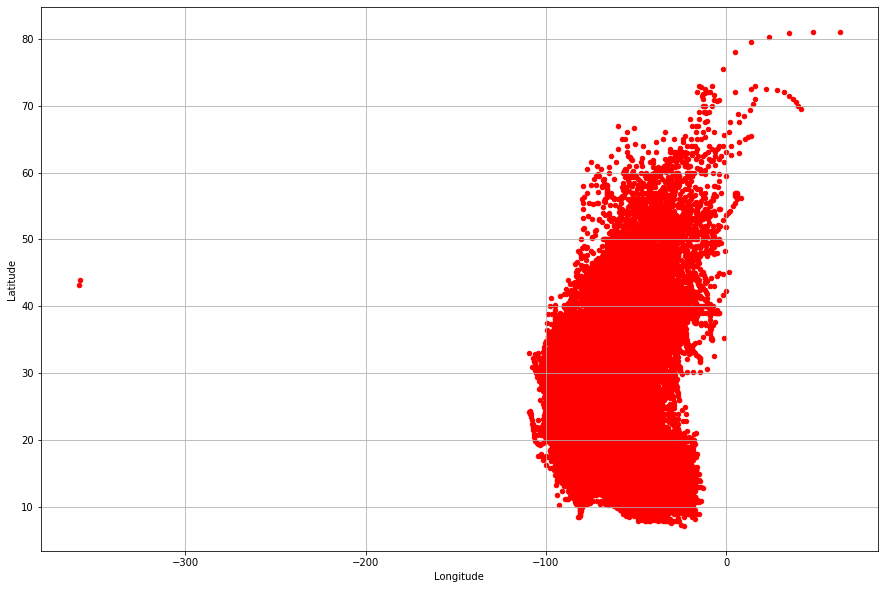

In [10]:
data.plot("Longitude","Latitude",kind="scatter",grid=True,color="red",figsize=(15,10))

Usually, statistical methods such as the standard deviation could be used to eleminate outliers. but in a case this clear, where a nice clustering is present and only a few outliers have Longitude values of under -300, we can manually eliminate them based on a threshold. For the outliers on the top right near the cluser, they are in a nice formation so that it seems logical that there was an exeptionally north and west storm on year, so no efforts to sliminate further storms will be made.  

Now, let's gain some statistical understanding of the numerical values.

In [11]:
data.describe()

,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,49105.000000,49105.000000,48767.000000,18436.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000
mean,27.044904,-65.682533,53.051695,992.244250,81.865394,76.518325,48.647188,59.156393,24.641952,23.029894,15.427293,18.403141,8.110117,7.357710,5.130890,6.269211
std,10.077880,19.687240,24.747884,19.113748,88.097930,87.563153,75.209183,77.568911,41.592337,42.017821,32.105372,35.411258,19.792002,18.730334,14.033464,16.876623
min,7.200000,-359.100000,10.000000,882.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.100000,-81.000000,35.000000,984.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.400000,-68.000000,50.000000,999.000000,60.000000,60.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.100000,-52.500000,70.000000,1006.000000,130.000000,120.000000,75.000000,90.000000,40.000000,35.000000,20.000000,30.000000,0.000000,0.000000,0.000000,0.000000
max,81.000000,63.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


Since the wind directions are separated in different columns and then set to zero if the wind doesnt come from that certain direction, the wind speed data points have mostly zero values. The 50 percentile is completely filled with those zero values for most of the columns. The zero values are therefore changed to np.NaN aswell.

,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,49105.000000,49102.000000,48767.000000,18436.000000,3837.000000,3674.000000,2861.000000,3298.000000,2159.000000,1994.000000,1660.000000,1826.000000,1190.000000,1154.000000,992.000000,1031.000000
mean,27.044904,-65.686546,53.051695,992.244250,126.329163,123.316549,100.678085,106.205276,67.579898,68.385155,55.027108,59.674151,40.352941,37.751300,30.625000,36.003880
std,10.077880,19.681145,24.747884,19.113748,79.744560,81.149871,80.425082,76.193733,42.925243,46.271414,38.701215,40.043340,25.459639,25.551839,19.872512,23.778631
min,7.200000,-359.100000,10.000000,882.000000,10.000000,10.000000,10.000000,10.000000,5.000000,5.000000,10.000000,10.000000,10.000000,10.000000,5.000000,10.000000
25%,19.100000,-81.000000,35.000000,984.000000,70.000000,60.000000,45.000000,50.000000,40.000000,30.000000,30.000000,30.000000,20.000000,20.000000,15.000000,20.000000
50%,26.400000,-68.000000,50.000000,999.000000,105.000000,100.000000,75.000000,90.000000,60.000000,60.000000,45.000000,50.000000,30.000000,30.000000,25.000000,30.000000
75%,33.100000,-52.500000,70.000000,1006.000000,160.000000,150.000000,120.000000,140.000000,90.000000,90.000000,70.000000,75.000000,50.000000,50.000000,40.000000,50.000000
max,81.000000,63.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


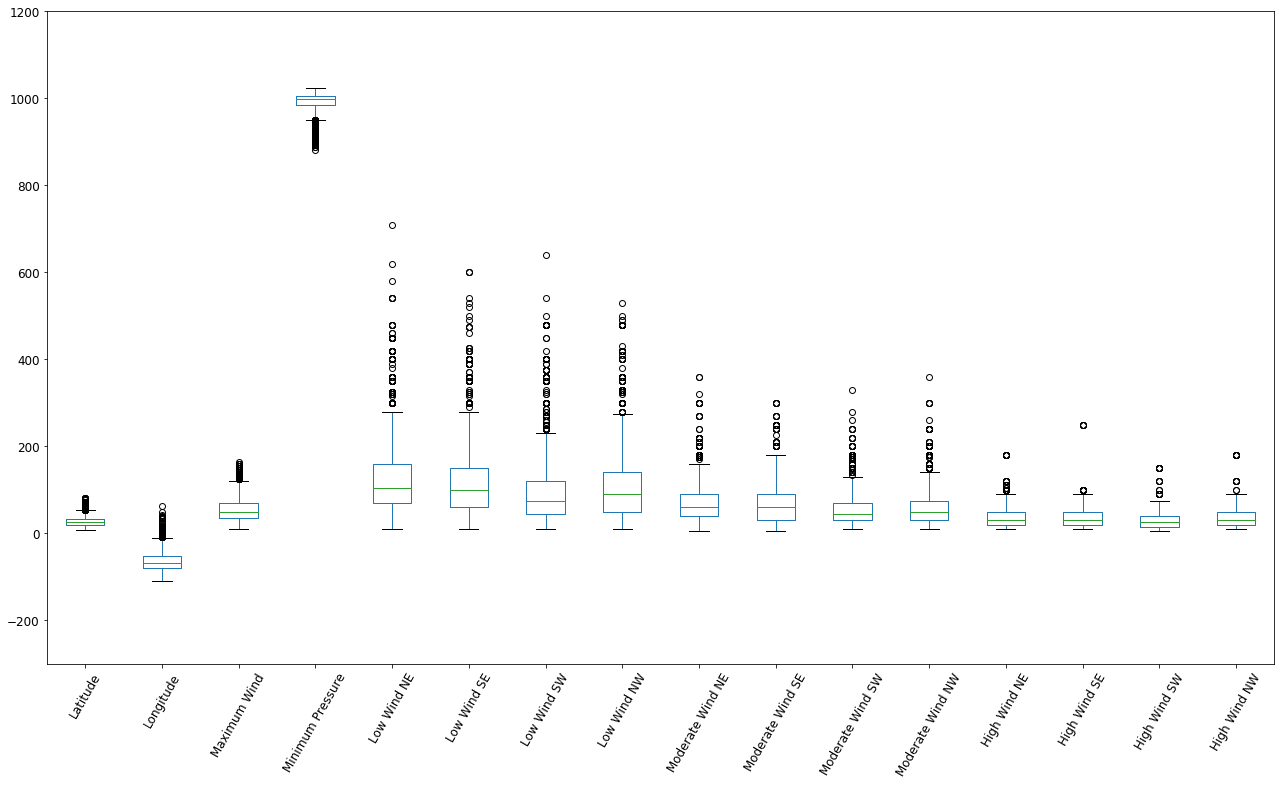

In [12]:
data = data.replace(0,np.NaN)
data.plot(kind="box",figsize=(22,12),rot=60,ylim=((-300,1200)),fontsize='large')
data.describe()

As usual, the boxes of the boxplot extend from Q1 to Q3 with the median line in the middle. Here, the whiskers extend up to the farthest data point within interquartal range ( 1,5*(Q3-Q1) ), the individual data points plotted as dots are considered outliers in this example.  
As seen before, the Longitude outliers are quite prominent here. Especially for the low wind data directional data points, quite a few outliers are detected, but some aswell for the high wind directional data points. Since the wind data itself will only be used to calculate the wind direction vector bearing and strength, there is no need at this point to remove the wind outliers.

In [13]:
""" Removing Longitude outlier rows """
len_before = len(data)
data = data[(data["Longitude"] > -300)]
print("Removed " + str(len_before-len(data)) + " rows with Latitude value lower than -300.")
del len_before

Removed 5 rows with Latitude value lower than -300.


## 2.2 Plot Hurricanes
Now, lets plot some hurricanes from selected years to have a look at their distributions. For that, the pandas dataframe is converted to geopandas and the gpd df assigned the SRS 4326. The plotting is executed in a method so that we can call the method later on again to plot certain hurricanes. The gpd is deleted afterwards, since we will continue working with the pd dataframe.

No. of Hurricanes in [1990, 1991, 1992, 1993, 1994]:  60


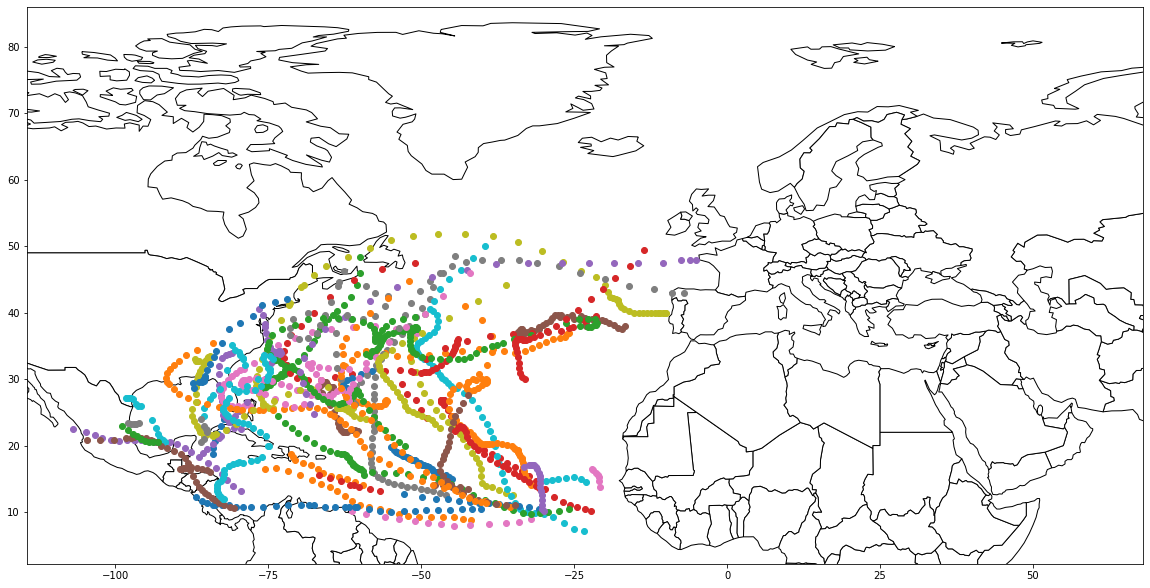

In [14]:
def plot_hurricanes(data,years):
    import geopandas as gpd
    import geoplot
    # convert to gpd based on geometries
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude,data.Latitude))
    # set SRS
    gdf = gdf.set_crs(epsg=4326)

    """get total bounding box """
    bb_all = gdf.bounds
    bb_min_x = bb_all["minx"].min() - 5
    bb_min_y = bb_all["miny"].min() - 5
    bb_max_x = bb_all["maxx"].max() + 5
    bb_max_y = bb_all["maxy"].max() + 5

    """ plot all hurricanesof certain years, color coded by IDs """
    # get world boundaries
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    # create ax and plot world
    ax = world.plot(color='white', edgecolor='black',figsize=(20,20))
    # set limits from BBs
    ax.set_xlim(bb_min_x, bb_max_x)
    ax.set_ylim(bb_min_y, bb_max_y)

    # cyle through IDs, filter by years, plot each point
    hur_ls = gdf["ID"].unique()
    hur_ls_years = []
    for i in hur_ls:
        if int(i[4:]) in years:
            hur_ls_years.append(i)
    print("No. of Hurricanes in "+str(years)+": ",len(hur_ls_years))
    for hur in hur_ls_years:
        hur_point = gdf[(gdf["ID"].str.contains(hur))]
        hur_point.plot(ax=ax)

    del bb_all,bb_min_y,bb_max_x,bb_max_y,world,ax,years,hur_ls,hur_ls_years,i,hur,hur_point

plot_hurricanes(data,[1990,1991,1992,1993,1994])

# 3. Feature Engineering  
Now, we create the features that the prediciton will be based on.  
## 3.1 Calculate Speed and Bearing to previous data point/s  

* The distance is caluclated, but not used. Uneven time delays in data aquisition might mean that a datapoint was 12 hrs instead of 6 hrs in the past, therefore skewing the distance parameter. To counteract this, the average speed was calculated since this takes the time dimension into account and is basically a function of the distance traveled.
* The speed is calculated by looking at the distance traveled from the according last data point and the time delay between the points
* The bearing is calculated according to https://gist.github.com/jeromer/2005586 (published with a public domain licens) from the hurricane point to the -n point in time (in this case 1,2,5,10).

In [15]:
import haversine

# returns compass bearing for 2 points
def get_bearing(pointA, pointB):
    import math
    """ taken from https://gist.github.com/jeromer/2005586, public domain license"""
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")
    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])
    diffLong = math.radians(pointB[1] - pointA[1])
    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)* math.cos(lat2) * math.cos(diffLong))
    initial_bearing = math.atan2(x, y)
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360
    return compass_bearing



ids = list(data["ID"])
lon = list(data["Longitude"])
lat = list(data["Latitude"])
loc_tuples = []
timestamp = list(data["Timestamp"])
unique_hurricanes = list(data["ID"].unique())

# create location tuples list
for a,b in zip(lon,lat):
    loc_tuples.append((a,b))

# Calculate distance, speed and bearing to previous data point/s
def calculate_dist_speed_bearing_from_loc(ids,loc_tuples,timestamp,data_point):
    # iteration structure adapted with permission from 'distance calculation' by Gil Salvans
    # https://github.com/gilsalvans/WS_DataScience_SalvansTorras/blob/main/Salvans_notebook_20W856113.ipynb (Field 33)
    # additionally implemented speed and bearing calc
    # additionally implemented dynamic choice of how far back in time the data is taken
    distance = []
    speed = []
    bearing = []
    for i in range(len(ids)):
        if ids[i] == ids[i-data_point]: 
            try:
                #calculate distance
                loc1 = loc_tuples[i-data_point]
                loc2 = loc_tuples[i]
                dist = haversine.haversine(loc1,loc2)
                dist = round(dist,2)
                
                
                #calculate speed
                tim1 = timestamp[i-data_point]
                tim2 = timestamp[i]
                duration = tim2 - tim1 # diffrence in timestamp (time format)
                duration_in_s = duration.total_seconds() # convert difference to seconds
                
                
                # calculate speed in kmh formula: (dist in m / time in s) = meter/second ... *3,6 = speed in km/h
                speed_kmh = round(((dist*1000)/duration_in_s)*3.6,2)
               
                # calculate bearing between two points, round to 2 dec
                bearing_temp = round(get_bearing(loc1,loc2),2)
                
                # divide distance by data point before appending, giving the average distance per data point over the last 10 data points
                dist = dist/data_point
                
                # append values to list
                distance.append(dist) # append distance in m to list
                speed.append(speed_kmh)
                bearing.append(bearing_temp)
                
                
            # catch errors
            except:
                distance.append(np.nan)
                speed.append(np.nan)
                bearing.append(np.nan)
        
        # if no data point in time -n
        else:
            distance.append(np.nan)
            speed.append(np.nan)
            bearing.append(np.nan)
    
    #remove 0 values from lists
    for n, i in enumerate(distance):
        if i == 0:
            distance[n] = np.NaN
    for n, i in enumerate(speed):
        if i == 0:
            speed[n] = np.NaN
    for n, i in enumerate(bearing):
        if i == 0:
            bearing[n] = np.NaN
    
    # return lists w/ calculated & cleaned values
    return speed,bearing


# call function and save results to list
speed_1,bearing_1 = calculate_dist_speed_bearing_from_loc(ids,loc_tuples,timestamp,1)
speed_2,bearing_2 = calculate_dist_speed_bearing_from_loc(ids,loc_tuples,timestamp,2)
speed_3,bearing_3 = calculate_dist_speed_bearing_from_loc(ids,loc_tuples,timestamp,3)
speed_4,bearing_4 = calculate_dist_speed_bearing_from_loc(ids,loc_tuples,timestamp,4)
speed_5,bearing_5 = calculate_dist_speed_bearing_from_loc(ids,loc_tuples,timestamp,5)

# append results to pd.DF
data["speed_1"], data["bearing_1"] = [speed_1,bearing_1]
data["speed_2"], data["bearing_2"] = [speed_2,bearing_2]
data["speed_3"], data["bearing_3"] = [speed_3,bearing_3]
data["speed_4"], data["bearing_4"] = [speed_4,bearing_4]
data["speed_5"], data["bearing_5"] = [speed_5,bearing_5]

## 3.2 Low/Moderate/High Wind Average Heading and Strength

Since the wind strengths are split up in the 4 directions per low/moderate/high zone, these cam be aggregated. The goal is to calculate the total bearing by combining all directional vectors and the according strength of the wind. 
  
The bearing is calculated by the following schema:  
![schema image](https://www.donike.net/wp-content/uploads/wind_bearing_schema.png "Schema Image")  
  
The orange cross represents the bearing directions as given by the original data, since they are in North West etc. The red points show the according values along those axes, while the green cross represents the point of both bearing (angle to origin) and wind strength (distance from origin), having weighted the vector against each other. The point is calculated by the following formula:  
x = ( (SW+SE)/2 ) -  ( (NW+NE)/2 )  
y = ( (NW+SW)/2 ) -  ( (NE+SE)/2 )  
distance from point to origin: sqrt( ((x2-x1)^2) + ((y2-y1)^2) )  

The bearing is then calculated according to https://gist.github.com/jeromer/2005586 from the origin to the point. Then, this number needs to be corrected since the original data is not given in the 4 cardinal directions, while the bearing calculator returns a compass heading. For that, 90 is added to the compass bearing; if the bearing would rise over 360 it is corrected again to represent a normal positive bearing.  
This process is repeated for low, moderate, and high winds and yields the strength and speed as returns for each.

In [16]:
"""Append aggregated wind bearing and strength to data"""

# Order: "Low Wind NE","Low Wind SE","Low Wind SW","Low Wind NW"
low_wind = [list(data["Low Wind NE"]),list(data["Low Wind SE"]),list(data["Low Wind SW"]),list(data["Low Wind NW"])]
mod_wind = [list(data["Moderate Wind NE"]),list(data["Moderate Wind SE"]),list(data["Moderate Wind SW"]),list(data["Moderate Wind NW"])]
high_wind = [list(data["High Wind NE"]),list(data["High Wind SE"]),list(data["High Wind SW"]),list(data["High Wind NW"])]



def get_distance(x1,y1,x2,y2):
    return math.sqrt( ((x2-x1)**2) + ((y2-y1)**2) )


# returns distance of wind avg. point as well as bearing
def get_wind_info(wind_list):
    wind_strength = []
    wind_bearing = []
    for NE,SE,SW,NW in zip(wind_list[0],wind_list[1],wind_list[2],wind_list[3]):
        if math.isnan(NE)==True:
            NE = 0
        if math.isnan(SE)==True:
            SE = 0
        if math.isnan(SW)==True:
            SW = 0
        if math.isnan(NW)==True:
            NW = 0
        ns_agg = ( (SW+SE)/2 ) -  ( (NW+NE)/2 )
        we_agg = ( (NW+SW)/2 ) -  ( (NE+SE)/2 )

        wind_strength.append(get_distance(0,0,we_agg,ns_agg))
        wind_bearing.append(get_bearing((0,0),(we_agg,ns_agg)))
        
    # add 90 to turn diagonal compass cross upright and correct compass bearing
    wind_bearing_corrected = []
    counter=0
    for i in wind_bearing:
        if i!=0:
            i = i+90
            # if result over 90, substract 360 to "swing around" value back to positive bearing
            if i >=360:
                i = i-360
            wind_bearing_corrected.append(i)
        else:
            wind_bearing_corrected.append(0)
    
    wind_bearing = wind_bearing_corrected
    return wind_strength,wind_bearing

low_wind_strength,low_wind_bearing = get_wind_info(low_wind)
mod_wind_strength, mod_wind_bearing = get_wind_info(mod_wind)
high_wind_strength, high_wind_bearing = get_wind_info(high_wind)

data["Low Wind Directional Strength"] = low_wind_strength
data["Moderate Wind Directional Strength"] = mod_wind_strength
data["High Wind Directional Strength"] = high_wind_strength
data["Low Wind Bearing"] = low_wind_bearing
data["Moderate Wind Bearing"] = mod_wind_bearing
data["High Wind Bearing"] = high_wind_bearing

# since the zero values in the newly created columns are 0 if there is no info, they are translated back to np.NaN
data["Low Wind Directional Strength"] = data["Low Wind Directional Strength"].replace(0,np.NaN)
data["Moderate Wind Directional Strength"] = data["Moderate Wind Directional Strength"].replace(0,np.NaN)
data["High Wind Directional Strength"] = data["High Wind Directional Strength"].replace(0,np.NaN)
data["Low Wind Bearing"] = data["Low Wind Bearing"].replace(0,np.NaN)
data["Moderate Wind Bearing"] = data["Moderate Wind Bearing"].replace(0,np.NaN)
data["High Wind Bearing"] = data["High Wind Bearing"].replace(0,np.NaN)

# dropping the wind values that were aggregated
data = data.drop(["Low Wind NE","Low Wind NW","Low Wind SE","Low Wind SW" ], axis=1)
data = data.drop(["Moderate Wind NE","Moderate Wind NW","Moderate Wind SE","Moderate Wind SW" ], axis=1)
data = data.drop(["High Wind NE","High Wind NW","High Wind SE","High Wind SW" ], axis=1)

del low_wind_strength,mod_wind_strength,high_wind_strength,low_wind_bearing,mod_wind_bearing,high_wind_bearing

# 3.3 Cleaning of created features  
## 3.3.1 Removal of Data Points over Land
While researching the formation and movements of hurricane, it became evident that as soon as the hurricanes reach land, their movement and speed is substantially different thatn over water and therefore harder to predict (https://oceanexplorer.noaa.gov/facts/hurricanes.html). therefore, the data points which are over land are eliminated. Now that the dataframe contains a column that indicates the country in which that point falls (nan if it is over water), a plot is created to make sure that the spatial join worked and the projections were correct.

Removed 5791 data points over land.


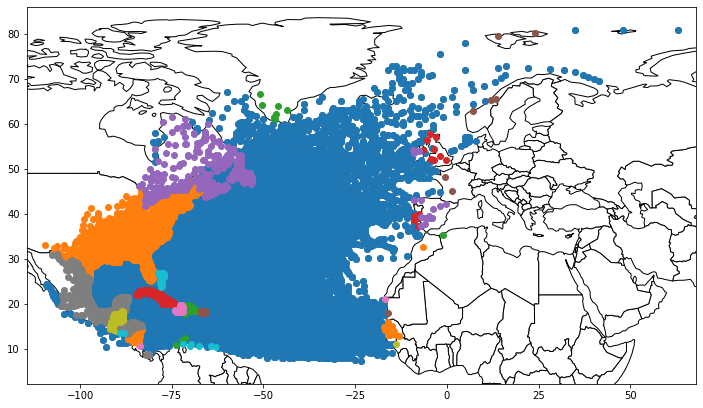

In [17]:
""" Point sampling to check if point over water, adding column with country info """
# Loarding world shape as gpd.df, removing unseless column
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


from geopandas.tools import sjoin
#transform pd.df to geopandas df
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude,data.Latitude))
# set SRS
gdf = gdf.set_crs(epsg=4326)
# spatial join of data and world, adding world info to data
gdf = sjoin(gdf, world, how='left')
gdf = gdf.drop(["gdp_md_est","index_right","pop_est","continent","name"],axis=1)
# float nan to empty string in gdf iso_a3
iso_list = list(gdf["iso_a3"])
for n, i in enumerate(iso_list):
        if type(i)!=str:
            if math.isnan(i):
                iso_list[n] = ""
gdf["iso_a3"]=iso_list
            
""" Plotting points identifies as over water """
# set up ax with world as background
ax = world.plot(color='white', edgecolor='black',figsize=(12,12))
# calculate BB +/- 5 and set x/y limits for ax
bb_all = gdf.bounds
bb_min_x = bb_all["minx"].min() - 5
bb_min_y = bb_all["miny"].min() - 5
bb_max_x = bb_all["maxx"].max() + 5
bb_max_y = bb_all["maxy"].max() + 5
ax.set_xlim(bb_min_x, bb_max_x)
ax.set_ylim(bb_min_y, bb_max_y)
# get unique country series
countries = gdf["iso_a3"].unique()
# plot all points in gray as background
gdf.plot(ax=ax,zorder=0,color="gray")
# plot points by individual country to get dif colors
for i in countries:
    if i != np.nan:
        hur_point = gdf[ (gdf["iso_a3"]==i)]
        hur_point.plot(ax=ax)
        
""" Remove data points over land """
len_before = len(gdf)
gdf = gdf[gdf["iso_a3"] == ""]
print("Removed " + str(len_before-len(gdf)) + " data points over land.")

gdf = gdf.drop(["iso_a3"],axis=1)

## 3.3.2 Removal of Data Points outside of Atlantic Ocean
Additionally, the points are masked to only include those data points that fall into the 'International Hydrographic Organization's definition of the Atlantic Ocean. Since the genesis and development of Hurricanes takes place in those waters, the other data points (in the Arctic Ocean or Pacific for example)  might taint the dataset, since the physical conditions are different in those areas.  
*Source*: https://www.marineregions.org/gazetteer.php?p=details&id=1912&from=rss, CC-BY

starting spatial join, this might take several minutes to complete (about 5 on geodatacomputing.com) due to the high accuracy of the atlantic layer ...
 ... spatial join finished after 343s
Removed 386 data points outside atlantic ocean.


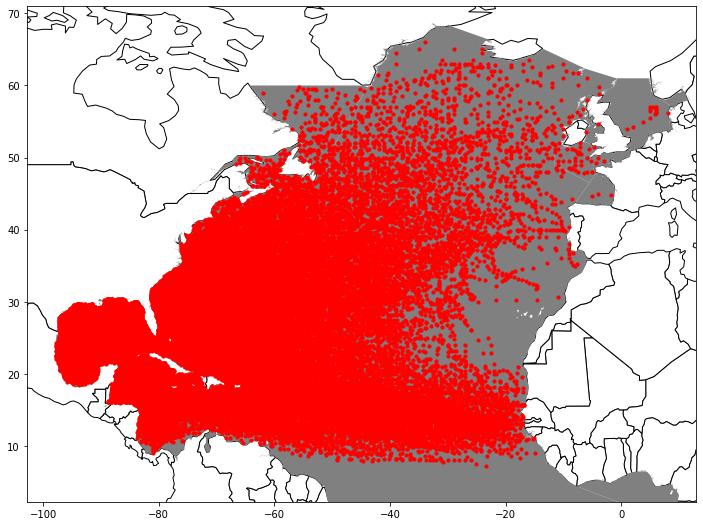

In [18]:
""" mask atlantoc ocean """
atlantic = gpd.read_file("data/shp_files/iho.shp")
atlantic = atlantic.drop(["id","longitude","latitude","min_x","min_y","max_x","max_y","area","mrgid"],axis=1)

# spatial join of data and world, adding world info to data
print("starting spatial join, this might take several minutes to complete (about 5 on geodatacomputing.com) due to the high accuracy of the atlantic layer ...")
import time
start_time=time.time()
gdf = sjoin(gdf, atlantic, how='left')
print(" ... spatial join finished after "+str(int(time.time()-start_time))+"s")

# float nan to empty string in gdf iso_a3
arctic_list = list(gdf["name"])
for n, i in enumerate(arctic_list):
        if type(i)!=str:
            if math.isnan(i):
                arctic_list[n] = ""
gdf["name"]=arctic_list

""" Remove data points not in arctic ocean """
len_before = len(gdf)
gdf = gdf[gdf["name"] != ""]
print("Removed " + str(len_before-len(gdf)) + " data points outside atlantic ocean.")

# drop name column remaining from spatial join
gdf = gdf.drop(["name","index_right"],axis=1)

""" plot remaining data points over world map and atlantic ocean shp"""
ax = world.plot(color="white", edgecolor="black",figsize=(12,12))
# calculate BB +/- 5 and set x/y limits for ax
bb_all = gdf.bounds
bb_min_x = bb_all["minx"].min() - 5
bb_min_y = bb_all["miny"].min() - 5
bb_max_x = bb_all["maxx"].max() + 5
bb_max_y = bb_all["maxy"].max() + 5
ax.set_xlim(bb_min_x, bb_max_x)
ax.set_ylim(bb_min_y, bb_max_y)
atlantic.plot(ax=ax,color="gray")
gdf.plot(ax=ax,color="red", markersize=10)

## 3.3.3 Statistical Cleaning of created features  
The created and now masked features are statistically cleaned, removing the outliers for wind strength and speed. Removing bearing outliers for both movement and wind is nonsensical. For both wind speed and movement speed, if the observed value has a z-factor of over 3 or under -3, it is removed and changed to np.NaN.
To perform the statistical cleaning, the geopandas dataframe is converted back to a normal pandas dataframe because the operations are easier this way.  
Additionally, the "minimum pressure" data point is removed fromthe dataset.

,Latitude,Longitude,Maximum Wind,speed_1,bearing_1,speed_2,bearing_2,speed_3,bearing_3,speed_4,bearing_4,speed_5,bearing_5,Low Wind Directional Strength,Moderate Wind Directional Strength,High Wind Directional Strength,Low Wind Bearing,Moderate Wind Bearing,High Wind Bearing
count,42923.000000,42923.000000,42646.000000,41024.000000,40338.000000,39340.000000,38959.000000,37636.000000,37392.000000,35942.000000,35772.000000,34271.000000,34150.000000,3677.000000,2025.000000,1119.000000,3397.000000,1811.000000,971.000000
mean,26.500874,-63.247991,54.609037,20.657467,127.644727,20.375754,127.254397,20.132531,126.623563,19.893344,125.794944,19.646626,125.050022,69.872092,37.302756,22.131125,260.253628,262.802165,264.530839
std,9.939298,18.844221,24.841300,17.006795,85.219448,16.424701,85.776417,15.941116,85.605280,15.489455,85.168751,15.062060,84.620351,58.400823,34.671463,23.771774,72.866299,72.805164,75.354314
min,7.200000,-97.800000,10.000000,0.020000,0.020000,0.020000,0.010000,0.020000,0.020000,0.060000,0.010000,0.020000,0.020000,3.535534,3.535534,3.535534,5.513852,5.175439,8.672584
25%,18.500000,-77.600000,35.000000,9.320000,34.532500,9.300000,33.280000,9.310000,32.887500,9.300000,32.387500,9.280000,32.302500,31.819805,15.811388,10.000000,244.961825,232.546280,239.434772
50%,25.700000,-64.900000,50.000000,16.910000,160.240000,16.830000,160.010000,16.780000,159.675000,16.710000,159.215000,16.680000,158.590000,55.226805,29.154759,15.811388,270.000000,274.981069,287.490583
75%,32.700000,-50.250000,70.000000,26.172500,177.290000,26.010000,177.190000,25.882500,177.090000,25.580000,176.990000,25.380000,176.840000,88.388348,45.276926,25.495098,310.893395,314.007027,314.753862
max,66.000000,8.000000,165.000000,206.570000,359.990000,160.190000,359.980000,142.300000,359.990000,129.430000,359.990000,119.120000,359.980000,491.172068,331.360831,217.830209,356.302324,354.923267,355.354355


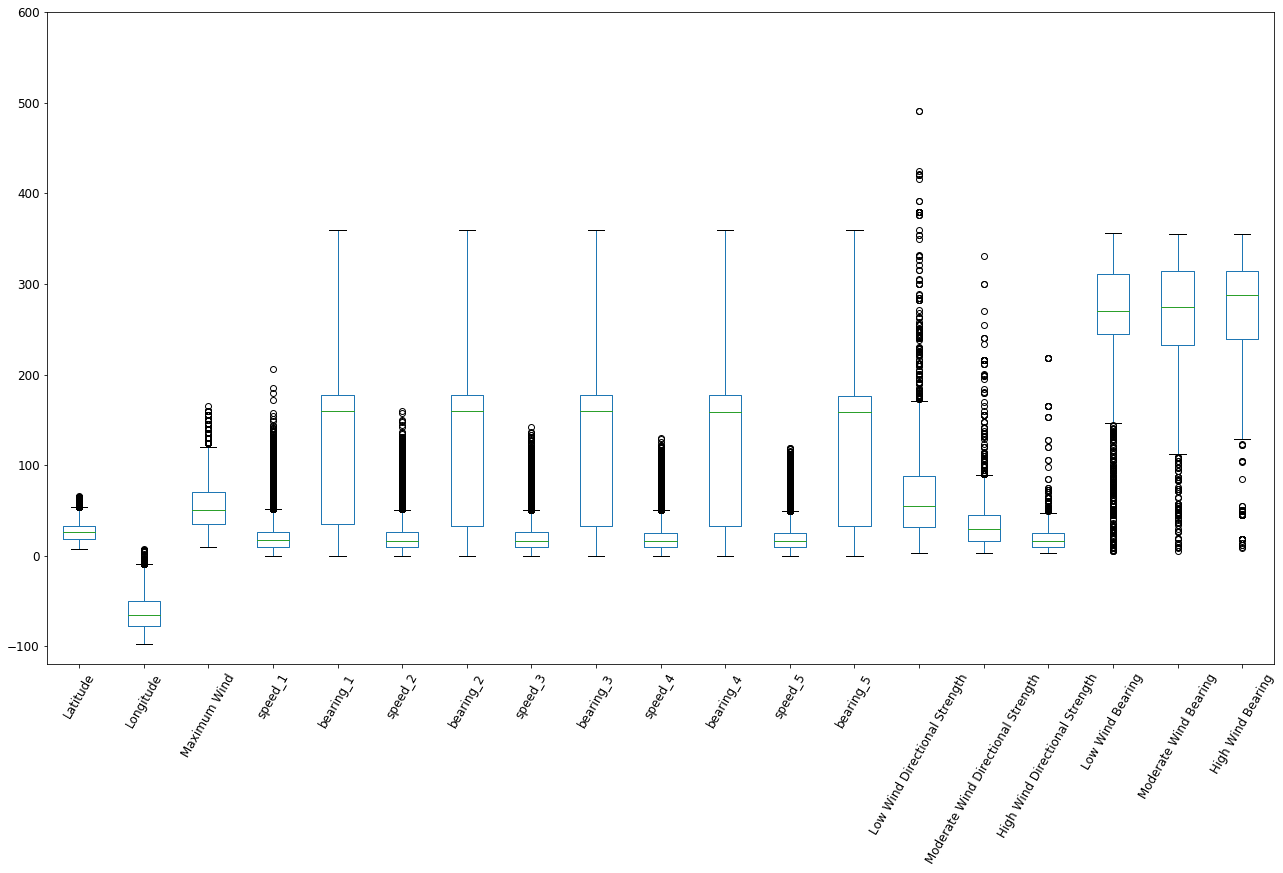

In [19]:
data = pd.DataFrame(gdf)
# remove geom column left over from gpd
data = data.drop(["geometry","Minimum Pressure","Event","Status"],axis=1)
# plot boxplot and show info
data.plot(kind="box",figsize=(22,12),rot=60,ylim=((-120,600)),fontsize='large')
data.describe()

Removing the outliers:

In [20]:
# takes list and value, replaces values over certain threshold with nan
import scipy.stats as stats

# iterate over z_list, replace data list with np.nan at according places
def replace_outliers(data_ls,z_ls,name_ls):
    counter = 0
    for n, i in enumerate(z_ls):
        if i > 3 or i < -3:
            counter = counter+1
            data_ls[n] = np.NaN
    print("Amount of values replaced in "+name_ls+" with z_facor >3 / <-3 : "+str(counter))
    return data_ls

# calculate list holding z values per column
z_speed_1 = list((data["speed_1"] - data["speed_1"].mean()) / data["speed_1"].std(ddof=0))
z_speed_2 = list((data["speed_2"] - data["speed_2"].mean()) / data["speed_2"].std(ddof=0))
z_speed_3 = list((data["speed_3"] - data["speed_3"].mean()) / data["speed_3"].std(ddof=0))
z_speed_4 = list((data["speed_4"] - data["speed_4"].mean()) / data["speed_4"].std(ddof=0))
z_speed_5 = list((data["speed_5"] - data["speed_5"].mean()) / data["speed_5"].std(ddof=0))
z_speed_wind_low = list((data["Low Wind Directional Strength"] - data["Low Wind Directional Strength"].mean()) / data["Low Wind Directional Strength"].std(ddof=0))
z_speed_wind_mod = list((data["Moderate Wind Directional Strength"] - data["Moderate Wind Directional Strength"].mean()) / data["Moderate Wind Directional Strength"].std(ddof=0))
z_speed_wind_high = list((data["High Wind Directional Strength"] - data["High Wind Directional Strength"].mean()) / data["High Wind Directional Strength"].std(ddof=0))


# call function, immediately save returned list as dataframe

data["speed_1"] = replace_outliers(list(data["speed_1"]),z_speed_1,"speed_1")
data["speed_2"] = replace_outliers(list(data["speed_2"]),z_speed_2,"speed_2")
data["speed_3"] = replace_outliers(list(data["speed_3"]),z_speed_3,"speed_3")
data["speed_4"] = replace_outliers(list(data["speed_4"]),z_speed_4,"speed_4")
data["speed_5"] = replace_outliers(list(data["speed_5"]),z_speed_5,"speed_5")
data["Low Wind Directional Strength"] = replace_outliers(list(data["Low Wind Directional Strength"]),z_speed_wind_low,"Low Wind Directional Strength")
data["Moderate Wind Directional Strength"] = replace_outliers(list(data["Moderate Wind Directional Strength"]),z_speed_wind_mod,"Moderate Wind Directional Strength")
data["High Wind Directional Strength"] = replace_outliers(list(data["High Wind Directional Strength"]),z_speed_wind_high,"High Wind Directional Strength")

""" Finally, the wind columns are renamed to somethig more machine-friendly """
data = data.rename(columns={"Low Wind Directional Strength": "low_wind_speed","Moderate Wind Directional Strength": "mod_wind_speed","High Wind Directional Strength": "high_wind_speed"})
data = data.rename(columns={"Low Wind Bearing": "low_wind_bear","Moderate Wind Bearing": "mod_wind_bear","High Wind Bearing": "high_wind_bear","Maximum Wind":"max_wind"})

Amount of values replaced in speed_1 with z_facor >3 / <-3 : 906
Amount of values replaced in speed_2 with z_facor >3 / <-3 : 872
Amount of values replaced in speed_3 with z_facor >3 / <-3 : 822
Amount of values replaced in speed_4 with z_facor >3 / <-3 : 776
Amount of values replaced in speed_5 with z_facor >3 / <-3 : 720
Amount of values replaced in Low Wind Directional Strength with z_facor >3 / <-3 : 87
Amount of values replaced in Moderate Wind Directional Strength with z_facor >3 / <-3 : 47
Amount of values replaced in High Wind Directional Strength with z_facor >3 / <-3 : 20


Before normalization, lets have a look at the data and see if the values still make sense.  
 

In [21]:
data.describe()

,Latitude,Longitude,max_wind,speed_1,bearing_1,speed_2,bearing_2,speed_3,bearing_3,speed_4,bearing_4,speed_5,bearing_5,low_wind_speed,mod_wind_speed,high_wind_speed,low_wind_bear,mod_wind_bear,high_wind_bear
count,42923.000000,42923.000000,42646.000000,40118.000000,40338.000000,38468.000000,38959.000000,36814.000000,37392.000000,35166.000000,35772.000000,33551.000000,34150.000000,3590.000000,1978.000000,1099.000000,3397.000000,1811.000000,971.000000
mean,26.500874,-63.247991,54.609037,19.061050,127.644727,18.849687,127.254397,18.683524,126.623563,18.513040,125.794944,18.345744,125.050022,63.911144,33.429292,19.639071,260.253628,262.802165,264.530839
std,9.939298,18.844221,24.841300,13.178984,85.219448,12.862208,85.776417,12.618011,85.605280,12.373819,85.168751,12.159968,84.620351,43.501330,23.209398,14.088042,72.866299,72.805164,75.354314
min,7.200000,-97.800000,10.000000,0.020000,0.020000,0.020000,0.010000,0.020000,0.020000,0.060000,0.010000,0.020000,0.020000,3.535534,3.535534,3.535534,5.513852,5.175439,8.672584
25%,18.500000,-77.600000,35.000000,9.280000,34.532500,9.270000,33.280000,9.270000,32.887500,9.260000,32.387500,9.105000,32.302500,31.622777,15.811388,10.000000,244.961825,232.546280,239.434772
50%,25.700000,-64.900000,50.000000,16.720000,160.240000,16.680000,160.010000,16.550000,159.675000,16.395000,159.215000,16.320000,158.590000,53.676992,29.154759,15.811388,270.000000,274.981069,287.490583
75%,32.700000,-50.250000,70.000000,25.950000,177.290000,25.150000,177.190000,25.020000,177.090000,24.870000,176.990000,24.660000,176.840000,84.852814,44.616048,25.000000,310.893395,314.007027,314.753862
max,66.000000,8.000000,165.000000,71.650000,359.990000,69.640000,359.980000,67.920000,359.990000,66.360000,359.990000,64.810000,359.980000,244.182309,137.885822,84.852814,356.302324,354.923267,355.354355


Judging by the bearing, which are mostly in the range of 270, the process seems to have worked. As evident by the map and the behaviour of hurricanes, they usually move West or West-South-West over the atlantic, which corresponds to the mean heading of about 250-260° for each wind altitude zone.  
The mean directional strength wind speed also nicely fits to the mean wind speeds of the altitude zones, having the highest values (ca. 75 and 71 for the directional wind) at the bottom, moderate values (ca. 45 and 37 for the directional wind) in the middle and then the lowest values (ca. 35 and 22 for the directional wind) at the top. It makes sense that the directional values are lower, since measured winds in different directions cancel each other out and therefore lower the calculated value.

## 3.3.4 Normalization - MinMax

In [22]:
""" MinMax Scaling """
# keep copy of original data
data_raw = data.copy(deep=True)

from sklearn import preprocessing
#set up scaler
scaler = preprocessing.MinMaxScaler()

data["max_wind_sc"] = scaler.fit_transform(data.max_wind.values.reshape(-1,1))

data["speed_1_sc"] = scaler.fit_transform(data.speed_1.values.reshape(-1,1))
data["speed_2_sc"] = scaler.fit_transform(data.speed_2.values.reshape(-1,1))
data["speed_3_sc"] = scaler.fit_transform(data.speed_3.values.reshape(-1,1))
data["speed_4_sc"] = scaler.fit_transform(data.speed_4.values.reshape(-1,1))
data["speed_5_sc"] = scaler.fit_transform(data.speed_5.values.reshape(-1,1))

data["bearing_1_sc"] = scaler.fit_transform(data.bearing_1.values.reshape(-1,1))
data["bearing_2_sc"] = scaler.fit_transform(data.bearing_2.values.reshape(-1,1))
data["bearing_3_sc"] = scaler.fit_transform(data.bearing_3.values.reshape(-1,1))
data["bearing_4_sc"] = scaler.fit_transform(data.bearing_4.values.reshape(-1,1))
data["bearing_5_sc"] = scaler.fit_transform(data.bearing_5.values.reshape(-1,1))

data["low_wind_speed_sc"] = scaler.fit_transform(data.low_wind_speed.values.reshape(-1,1))
data["mod_wind_speed_sc"] = scaler.fit_transform(data.mod_wind_speed.values.reshape(-1,1))
data["high_wind_speed_sc"] = scaler.fit_transform(data.high_wind_speed.values.reshape(-1,1))

data["low_wind_bear_sc"] = scaler.fit_transform(data.low_wind_bear.values.reshape(-1,1))
data["mod_wind_bear_sc"] = scaler.fit_transform(data.mod_wind_bear.values.reshape(-1,1))
data["high_wind_bear_sc"] = scaler.fit_transform(data.high_wind_bear.values.reshape(-1,1))

#data = data.drop(["speed_2","speed_3","speed_4","speed_5","bearing_2","bearing_3","bearing_4","bearing_5"],axis=1)
#data = data.drop(["max_wind","low_wind_bear","mod_wind_bear","high_wind_bear","low_wind_speed","mod_wind_speed","high_wind_speed"],axis=1)

# reorder dataset
data = data[["Latitude","Longitude","max_wind","speed_1","speed_2","speed_3","speed_4","speed_5","bearing_1","bearing_2","bearing_3","bearing_4","bearing_5","speed_1_sc","speed_2_sc","speed_3_sc","speed_4_sc","speed_5_sc","bearing_1_sc","bearing_2_sc","bearing_3_sc","bearing_4_sc","bearing_5_sc","low_wind_speed_sc","mod_wind_speed_sc","high_wind_speed_sc","low_wind_bear_sc","mod_wind_bear_sc","high_wind_bear_sc"]]


#saving data used for prediction as pkl binary file
data.to_pickle("data/pred_data.pkl")

The result is the final data which will be used for prediction. It's saved in the working directory just to be sure.  
At the end of the dataset are speed_1 and bearing_1, which are the original values in their original values (km/h & compass bearing), since this is the 'truth' datapoint for the prediciton.  
   
    
Also, let's look at the normalized values dataset

In [23]:
data.describe()

,Latitude,Longitude,max_wind,speed_1,speed_2,speed_3,speed_4,speed_5,bearing_1,bearing_2,...,bearing_2_sc,bearing_3_sc,bearing_4_sc,bearing_5_sc,low_wind_speed_sc,mod_wind_speed_sc,high_wind_speed_sc,low_wind_bear_sc,mod_wind_bear_sc,high_wind_bear_sc
count,42923.000000,42923.000000,42646.000000,40118.000000,38468.000000,36814.000000,35166.000000,33551.000000,40338.000000,38959.000000,...,38959.000000,37392.000000,35772.000000,34150.000000,3590.000000,1978.000000,1099.000000,3397.000000,1811.000000,971.000000
mean,26.500874,-63.247991,54.609037,19.061050,18.849687,18.683524,18.513040,18.345744,127.644727,127.254397,...,0.353486,0.351706,0.349422,0.347344,0.250889,0.222506,0.198033,0.726192,0.736607,0.738021
std,9.939298,18.844221,24.841300,13.178984,12.862208,12.618011,12.373819,12.159968,85.219448,85.776417,...,0.238288,0.237812,0.236593,0.235083,0.180768,0.172753,0.173248,0.207721,0.208165,0.217359
min,7.200000,-97.800000,10.000000,0.020000,0.020000,0.020000,0.060000,0.020000,0.020000,0.010000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.500000,-77.600000,35.000000,9.280000,9.270000,9.270000,9.260000,9.105000,34.532500,33.280000,...,0.092424,0.091306,0.089942,0.089684,0.116716,0.091372,0.079497,0.682599,0.650099,0.665631
50%,25.700000,-64.900000,50.000000,16.720000,16.680000,16.550000,16.395000,16.320000,160.240000,160.010000,...,0.444481,0.443523,0.442261,0.440521,0.208361,0.190690,0.150962,0.753976,0.771429,0.804248
75%,32.700000,-50.250000,70.000000,25.950000,25.150000,25.020000,24.870000,24.660000,177.290000,177.190000,...,0.492208,0.491902,0.491638,0.491221,0.337911,0.305772,0.263959,0.870552,0.883012,0.882888
max,66.000000,8.000000,165.000000,71.650000,69.640000,67.920000,66.360000,64.810000,359.990000,359.980000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 3.4 Correlation of created features  

Lets look at the statistics for the newly created values, as well as the statistical correlations for each data point against each other data point.

In [24]:
data.corr(method='pearson')

,Latitude,Longitude,max_wind,speed_1,speed_2,speed_3,speed_4,speed_5,bearing_1,bearing_2,...,bearing_2_sc,bearing_3_sc,bearing_4_sc,bearing_5_sc,low_wind_speed_sc,mod_wind_speed_sc,high_wind_speed_sc,low_wind_bear_sc,mod_wind_bear_sc,high_wind_bear_sc
Latitude,1.000000,0.152522,0.104104,0.278761,0.275567,0.272592,0.270705,0.269768,-0.424316,-0.431950,...,-0.431950,-0.444078,-0.459966,-0.475529,0.315897,0.356426,0.380863,-0.334362,-0.438457,-0.432234
Longitude,0.152522,1.000000,-0.127146,0.393258,0.399979,0.403775,0.406860,0.409155,-0.082235,-0.093137,...,-0.093137,-0.103562,-0.115165,-0.130003,0.044792,0.090355,-0.046059,-0.148038,-0.220589,-0.162856
max_wind,0.104104,-0.127146,1.000000,-0.009297,-0.016149,-0.023889,-0.031385,-0.036879,-0.074000,-0.061212,...,-0.061212,-0.048142,-0.033165,-0.020443,-0.204175,-0.209353,-0.169987,0.168568,0.250408,0.295521
speed_1,0.278761,0.393258,-0.009297,1.000000,0.977334,0.945182,0.908138,0.868688,-0.224182,-0.243930,...,-0.243930,-0.262168,-0.280166,-0.298437,0.176769,0.200077,0.297797,-0.048444,-0.155047,-0.163534
speed_2,0.275567,0.399979,-0.016149,0.977334,1.000000,0.985688,0.958231,0.923989,-0.205637,-0.221290,...,-0.221290,-0.242166,-0.261752,-0.284001,0.177005,0.212487,0.313458,-0.042282,-0.147727,-0.150520
speed_3,0.272592,0.403775,-0.023889,0.945182,0.985688,1.000000,0.988922,0.964731,-0.187291,-0.204660,...,-0.204660,-0.220615,-0.241177,-0.264313,0.197149,0.219432,0.305032,-0.038941,-0.133682,-0.126111
speed_4,0.270705,0.406860,-0.031385,0.908138,0.958231,0.988922,1.000000,0.990862,-0.166031,-0.185349,...,-0.185349,-0.202704,-0.218060,-0.242599,0.207474,0.227894,0.301320,-0.027787,-0.114162,-0.105362
speed_5,0.269768,0.409155,-0.036879,0.868688,0.923989,0.964731,0.990862,1.000000,-0.148316,-0.168021,...,-0.168021,-0.186872,-0.202697,-0.220253,0.221042,0.241556,0.295554,-0.024336,-0.084946,-0.076876
bearing_1,-0.424316,-0.082235,-0.074000,-0.224182,-0.205637,-0.187291,-0.166031,-0.148316,1.000000,0.964393,...,0.964393,0.901292,0.843981,0.787505,-0.133908,-0.171723,-0.160476,-0.036814,0.144371,0.210461
bearing_2,-0.431950,-0.093137,-0.061212,-0.243930,-0.221290,-0.204660,-0.185349,-0.168021,0.964393,1.000000,...,1.000000,0.957699,0.894331,0.831970,-0.145834,-0.186479,-0.164312,-0.033113,0.150073,0.203554


# 4.0 Building Models and performing Prediction 
## 4.1 NN (Dense Layers) Speed and Bearing Prediction

Now, let's do the final data cleaning before the ML techniques start. Since they can not work when NaN values are included, those datapoints where there is no data for the 5 previous time frames are removed.  
Since for now we are only predicting based on speed and bearing, first the wind info is removed. The 'tanh' activation function is chosen because it minimizes the risk of dead neurons compared to 'relu'.

In [25]:
# copy dataset to NN
data_pred = data.copy(deep=True)
#data_pred = data_pred.drop(["low_wind_speed_sc","mod_wind_speed_sc","high_wind_speed_sc","low_wind_bear_sc","mod_wind_bear_sc","high_wind_bear_sc"],axis=1)
data_pred = data_pred[["Latitude","Longitude","max_wind","speed_1","speed_2","speed_3","speed_4","speed_5","bearing_1","bearing_2","bearing_3","bearing_4","bearing_5","speed_1_sc","speed_2_sc","speed_3_sc","speed_4_sc","speed_5_sc","bearing_1_sc","bearing_2_sc","bearing_3_sc","bearing_4_sc","bearing_5_sc"]]

# remove ros w/nan
len_before = len(data_pred)
data_pred = data_pred.dropna()
print("Removed datapoints that dont have at least 5 previous datapoints: "+str(len_before-len(data_pred)))
#data_pred.head(5)

#also drop from original dataset
#data_raw = data_raw.dropna()

Removed datapoints that dont have at least 5 previous datapoints: 10907


In [39]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import keras

In [40]:

# define model builder module
def build_model(data_pred,predictors,target,hidden_layer_activation):
    # set predictors
    X = data_pred[predictors]
    # set prediciton goals
    y = data_pred[target]
    # split dataset in training & testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=90)
    
    
    #CNN model definition 
    model = Sequential()
    model.add(keras.Input(shape=(len(predictors),))) # define input shape
    model.add(Dense(1, input_dim=1, activation=hidden_layer_activation, name='input_layer' ))
    model.add(Dense(3, activation=hidden_layer_activation, name='1st_hidden_layer' ))
    model.add(Dense(2, activation=hidden_layer_activation, name='2nd_hidden_layer' ))
    model.add(Dense(1, activation='linear', name='output_layer' ))

    # compile the keras model
    model.compile(loss='mse', optimizer='adam')
    return model,X_train, X_test, y_train, y_test,X,y


# build speed model
predictors_speed = ["speed_2_sc","speed_3_sc","speed_4_sc","speed_5_sc"]
target_speed = ["speed_1_sc"]
model_speed,X_train_speed, X_test_speed, y_train_speed, y_test_speed,X_speed,y_speed = build_model(data_pred,predictors_speed,target_speed,"tanh")



# build bearing model
predictors_bearing = ["bearing_2_sc","bearing_3_sc","bearing_4_sc","bearing_5_sc"]
target_bearing = ["bearing_1_sc"]
model_bearing,X_train_bearing, X_test_bearing, y_train_bearing, y_test_bearing,X_bearing,y_bearing = build_model(data_pred,predictors_bearing,target_bearing,"tanh")


# train on models
print("\n\t\tTrain speed")
fitting_speed = model_speed.fit(X_train_speed, y_train_speed, epochs=25, batch_size=100, verbose=1, validation_split=0.2)
print("\n\n\n\t\tTrain bearing")
fitting_bearing = model_bearing.fit(X_train_bearing, y_train_bearing, epochs=25, batch_size=50, verbose=1, validation_split=0.2)


		Train speed
Epoch 1/25
205/205 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0065
Epoch 2/25
205/205 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 3/25
205/205 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 4/25
205/205 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 5/25
205/205 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/25
205/205 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/25
205/205 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/25
205/205 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/25
205/205 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/25
205/205 [==============================] - 1s 7ms/step - loss: 0.0015 - v

relu issue: dead neurons - https://cs231n.github.io/neural-networks-1/#actfun

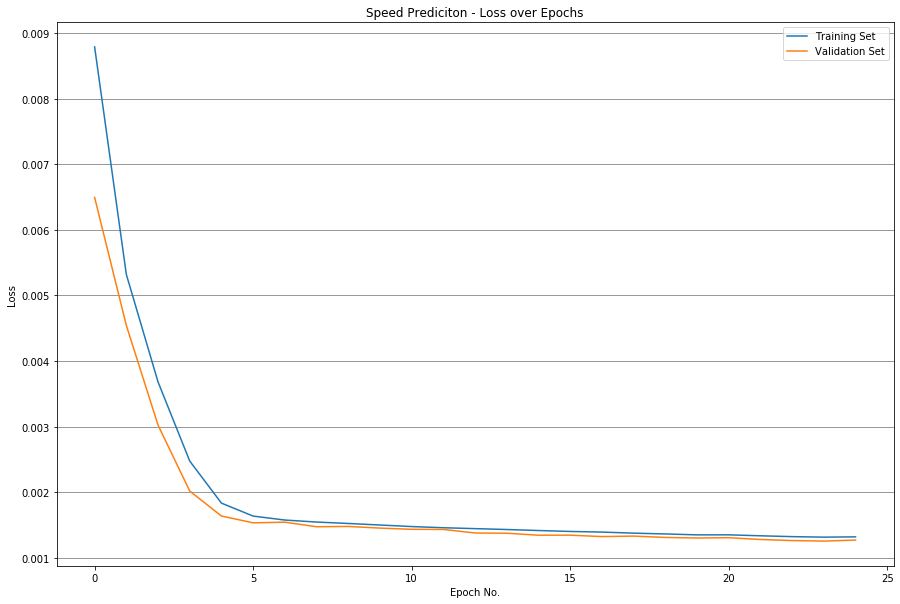

In [41]:
""" Plot Loss Graphs """
# Speed

plt.figure(figsize=(15,10))
plt.plot(fitting_speed.history['loss'])
plt.plot(fitting_speed.history['val_loss'])
plt.title("Speed Prediciton - Loss over Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch No.")
plt.grid(color="gray",axis="y")
plt.legend(["Training Set", "Validation Set"], loc='upper right')
plt.show()

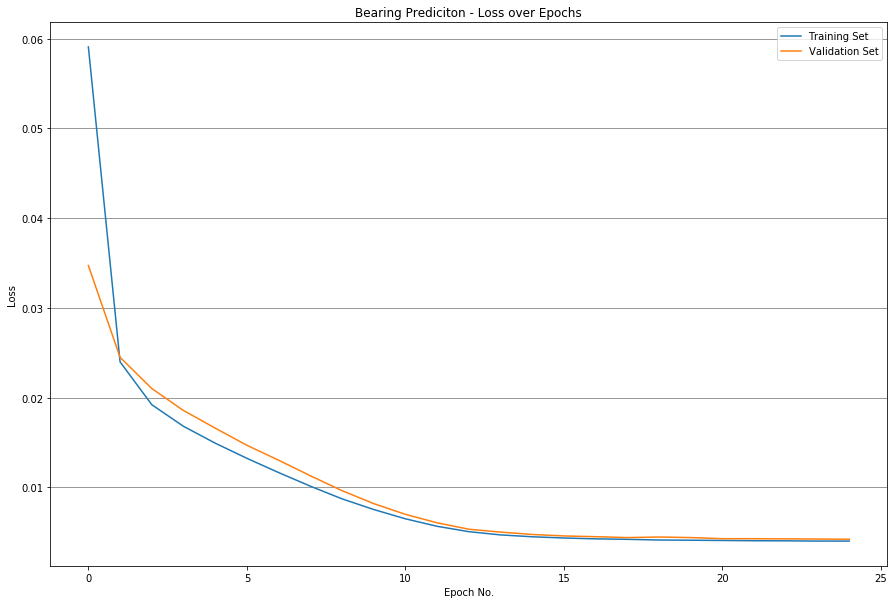

In [42]:
# Bearing
plt.figure(figsize=(15,10))
plt.plot(fitting_bearing.history['loss'])
plt.plot(fitting_bearing.history['val_loss'])
plt.title("Bearing Prediciton - Loss over Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch No.")
plt.grid(color="gray",axis="y")
plt.legend(["Training Set", "Validation Set"], loc='upper right')
plt.show()

Now that the models are built and the loss visualized, the prediction itself is performed. Note: The result is still normalized and has to be reconstructed in order to extract the actual speed value. But for the accuracy comparisons, the scaled values will be used.

In [43]:
# perform prediction
speed_pred = model_speed.predict(X_speed)
bearing_pred = model_bearing.predict(X_bearing)

# save predicitons to dataframe
data_pred["speed_pred_sc"]=speed_pred
data_pred["bearing_pred_sc"]=bearing_pred

## 4.2 NN (Dense Layers) Speed and Bearing Prediction Accuracy Assesment

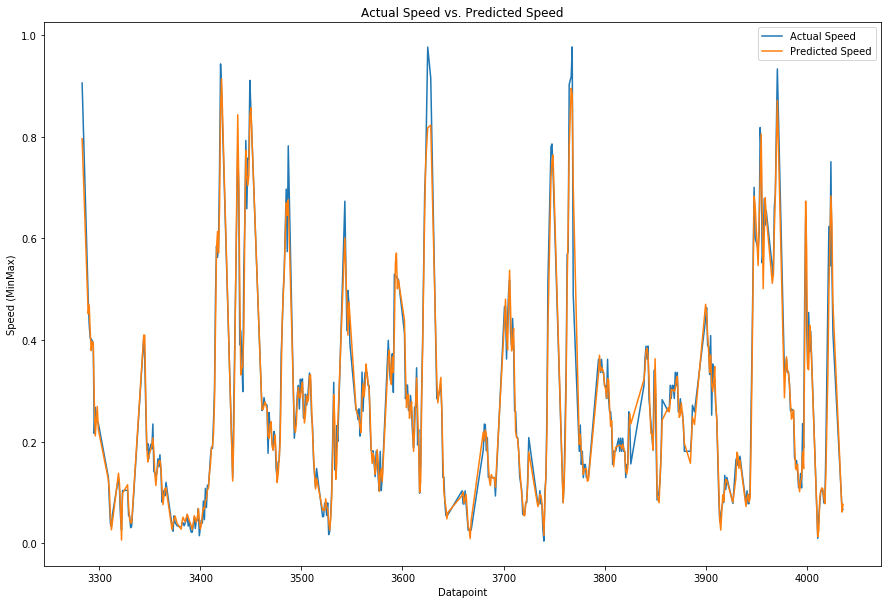

In [44]:
plt.figure(figsize=(15,10))
plt.plot(data_pred["speed_1_sc"][2000:2500])
plt.plot(data_pred["speed_pred_sc"][2000:2500])
plt.title("Actual Speed vs. Predicted Speed")
plt.ylabel("Speed (MinMax)")
plt.xlabel("Datapoint")
plt.legend(["Actual Speed", "Predicted Speed"], loc='upper right')
plt.show()

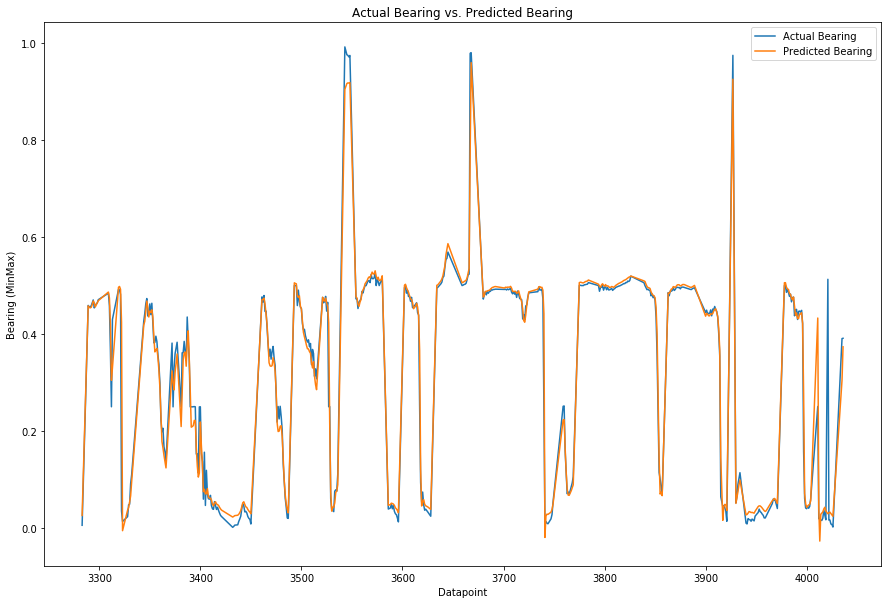

In [45]:
plt.figure(figsize=(15,10))
plt.plot(data_pred["bearing_1_sc"][2000:2500])
plt.plot(data_pred["bearing_pred_sc"][2000:2500])
plt.title("Actual Bearing vs. Predicted Bearing")
plt.ylabel("Bearing (MinMax)")
plt.xlabel("Datapoint")
plt.legend(["Actual Bearing", "Predicted Bearing"], loc='upper right')
plt.show()

## 4.3 Random Forest Regression Speed and Bearing Prediction

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# define speed labels and target
features_speed = data_pred[["speed_2","speed_3","speed_4","speed_5"]].to_numpy()
labels_speed = data_pred["speed_1"].to_numpy()

# define bearing labels and target
features_bearing = data_pred[["bearing_2","bearing_3","bearing_4","bearing_5"]].to_numpy()
labels_bearing = data_pred["bearing_1"].to_numpy()

train_features_speed_rf, test_features_speed_rf, train_labels_speed_rf, test_labels_speed_rf = train_test_split(features_speed, labels_speed, test_size = 0.15, random_state = 42)
train_features_bearing_rf, test_features_bearing_rf, train_labels_bearing_rf, test_labels_bearing_rf = train_test_split(features_bearing, labels_bearing, test_size = 0.15, random_state = 42)

# create speed and bearing rf  models
rf_speed = RandomForestRegressor(n_estimators = 200, random_state = 99, max_depth=10)
rf_bearing = RandomForestRegressor(n_estimators = 200, random_state = 99, max_depth=10)

# train speed and bearing models
rf_speed.fit(train_features_speed_rf, train_labels_speed_rf)
rf_bearing.fit(train_features_bearing_rf, train_labels_bearing_rf)

# predict speed and bearing values
speed_pred_rf = rf_speed.predict(features_speed)
bearing_pred_rf = rf_bearing.predict(features_bearing)


In [96]:
# write results to dataframe

#def strip_ls(ls):
#    tmp = []
#    for i in ls:
#        tmp.append(i[0])
#    return tmp

data_pred["speed_pred_rf"] = speed_pred_rf
data_pred["bearing_pred_rf"] = bearing_pred_rf

## 4.3 Random Forest Regression Speed and Bearing Prediction Accuracy Assesment

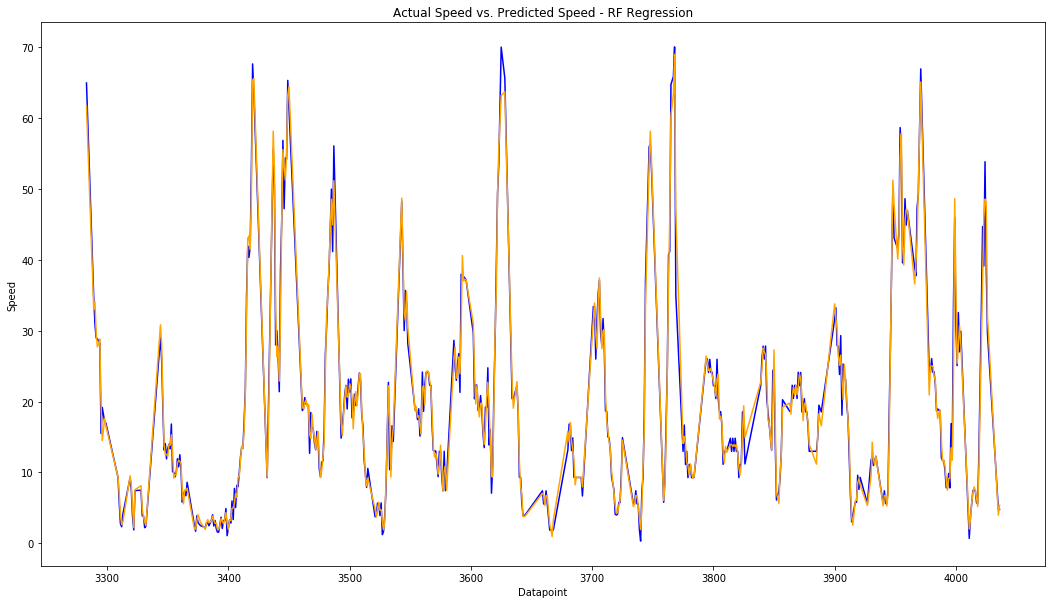

In [97]:
plt.figure(figsize=(18,10))
plt.plot(data_pred["speed_1"][2000:2500],color="blue")
plt.plot(data_pred["speed_pred_rf"][2000:2500],color="orange")
plt.title("Actual Speed vs. Predicted Speed - RF Regression")
plt.ylabel("Speed")
plt.xlabel("Datapoint")
#plt.legend(["Actual Bearing", "Predicted Bearing"], loc='upper right')
plt.show()

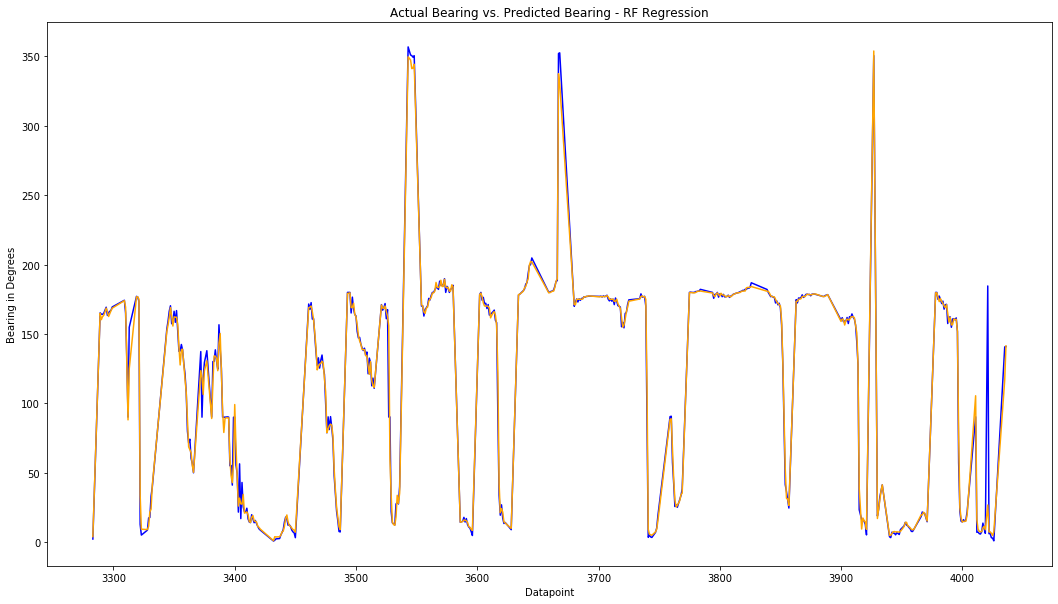

In [98]:
plt.figure(figsize=(18,10))
plt.plot(data_pred["bearing_1"][2000:2500],color="blue")
plt.plot(data_pred["bearing_pred_rf"][2000:2500],color="orange")
plt.title("Actual Bearing vs. Predicted Bearing - RF Regression")
plt.ylabel("Bearing in Degrees")
plt.xlabel("Datapoint")
#plt.legend(["Actual Bearing", "Predicted Bearing"], loc='upper right')
plt.show()

 Let's also look at one of the trees in the forest to gain an understanding of what is going on behind the scenes.

In [103]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
from sklearn import tree

#fn=data.feature_names
#cn=data.target_names
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=200)
#tree.plot_tree(rf_speed.estimators_[0],filled = True);
#fig.savefig('rf_individualtree.png')

# 5. Comparison and Conclusion
Having performed both the speed and bearing predictions using a NN and RF Regression, their performances are now compared.

In [100]:
# calculate r2 values
r2_NN_speed = r2_score(data_pred["speed_1_sc"],data_pred["speed_pred_sc"])
r2_NN_bearing = r2_score(data_pred["bearing_1_sc"],data_pred["bearing_pred_sc"])
r2_RF_speed = r2_score(data_pred["speed_1"],data_pred["speed_pred_rf"])
r2_RF_bearing = r2_score(data_pred["bearing_1"],data_pred["bearing_pred_rf"])

In [101]:
print("\n\t\t\tSpeed\t\t\tBearing")
print("R2  - NN\t",r2_NN_speed,"\t",r2_NN_bearing)
print("R2  - RF\t",r2_RF_speed,"\t",r2_RF_bearing)


			Speed			Bearing
R2  - NN	 0.9616243480266619 	 0.9267531741454479
R2  - RF	 0.978218848585285 	 0.9721433368711295


  
  
  
  Just for fun, a basic plot of one decision tree is created.

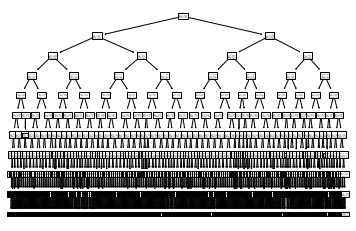

In [111]:
from sklearn.tree import export_graphviz
from subprocess import check_call
estimator = rf_speed.estimators_[5]
tree.plot_tree(estimator)
plt.show()

# 6. Combine Speed & Bearing to predict position  
The speed and bearing predictions are now combined to geometrically project the predicted position of the hurricane in 6 hours.